In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

In [2]:
# Function to grab data from yfinance
def get_stock(symbols, start_date_list, end_date_list = []):
    """
    Pulls financial data between start and end dates for specify stock.

    Params:
        symbols         : list of stock symbols to create csv files.
        start_date_list : start date in list form (i.e. [<year>, <month>, <day>]).
        end_date_list   : end date in list form (i.e. [<year>, <month>, <day>]).  It does not include the end dates.
        interval        : sample rate of data
        
    Returns:
        Stock data between a specific interval.
    """

    start = dt.date(start_date_list[0], start_date_list[1], start_date_list[2])
    
    if end_date_list == []:
        end = dt.date.today()
    else:
        end = dt.date(end_date_list[0], end_date_list[1], end_date_list[2])

    formatted_start_date = start.strftime("%Y%m%d")
    formatted_end_date = end.strftime("%Y%m%d")

    data = yf.download(symbols, start = start, end = end)

    col_name_change = {"Close": "close", "High": "high", "Low": "low", "Volume": "volume", "Open": "open", "Adj Close": "adj_close"}
    
    data.rename(columns = col_name_change, inplace = True)

    return data

In [3]:
# Selecting Stock via Stock Symbol
symbols = "BAC"

start_date_list = [2016, 1, 1]
end_date_list = [2022, 5, 19]

# Run the stock grabber function
data = get_stock(symbols, start_date_list, end_date_list)
print(data.head())
print(data.tail())
print(data.shape)

[*********************100%***********************]  1 of 1 completed
                 open       high    low  close  adj_close     volume
Date                                                                
2016-01-04  16.450001  16.490000  16.25  16.43  14.538152  114888000
2016-01-05  16.520000  16.590000  16.23  16.43  14.538152   66670000
2016-01-06  16.190001  16.290001  16.02  16.08  14.228452  102760800
2016-01-07  15.730000  15.900000  15.44  15.50  13.715240  116255900
2016-01-08  15.940000  15.940000  15.16  15.20  13.449781  124782400
                 open       high        low      close  adj_close    volume
Date                                                                       
2022-05-12  35.009998  35.430000  34.259998  35.070000  35.070000  61231500
2022-05-13  35.529999  35.730000  34.759998  35.169998  35.169998  49069300
2022-05-16  35.000000  35.169998  34.410000  34.810001  34.810001  39076500
2022-05-17  35.619999  36.220001  35.430000  35.990002  35.990002  4

<AxesSubplot:xlabel='Date'>

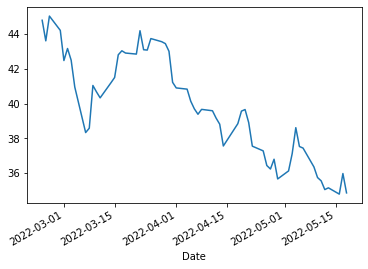

In [4]:
# Plot stock based on closing price from the last 60 days
stock_plot = data.iloc[-60:]
stock_plot['close'].plot()

In [5]:
# List of symbols for technical indicators to grab from finta library
finta_indicators = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [6]:
# Clean stock data and perform feature selection to create new technical indicator features that model can learn from
def exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are smoother
    """
    
    return data.ewm(alpha = alpha).mean()

<AxesSubplot:xlabel='Date'>

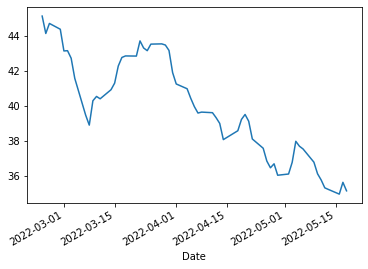

In [7]:
# Plot the smoothed out stock plot based on the last 60 days
data = exponential_smooth(data, 0.65)

stock_plot_smooth = data.iloc[-60:]
stock_plot_smooth['close'].plot()

In [8]:
# Function that uses the finta API to calculate indicators used for features
def get_indicator_data(data):
    """
    Function that uses the finta API to calculate indicators used as the features
    """

    for indicator in finta_indicators:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index = True, right_index = True)
    data.rename(columns = {"14 period EMV.": '14 period EMV'}, inplace = True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    data = data.drop(columns = ["open", "high", "low", "volume", "adj_close"])
    
    return data

data = get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [9]:
# Function creates column of predicted values
def produce_prediction(data, window):
    """
    Function that produces predicted values.  Looks ahead a specific amt and see if the prices increase (1) or decrease (0)
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

In [10]:
# Prints data with predictions and features
data = produce_prediction(data, window = 15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2022-04-21,35.988344,-1.077212,-1.052621,34.924157,1.535224e+09,1.102578,-0.837665,35.911602,-4.534898,9.398511e+09,-57.019501,-0.004419,1.192513,0.804351,0.907121,0.938353,0.956865,0.989851,0.894768,0.0
2022-04-22,30.648202,-1.116846,-1.065466,16.399226,1.495795e+09,1.098268,-1.482682,36.646182,-5.756174,9.348848e+09,-89.682779,-0.004522,1.186720,0.807675,0.885645,0.917633,0.936319,0.969997,0.932821,0.0
2022-04-25,28.283496,-1.177463,-1.087866,21.257545,1.513946e+09,1.122033,-2.065937,36.751868,-5.959192,9.289670e+09,-129.519702,-0.005888,1.213444,0.753798,0.875498,0.908796,0.928038,0.963487,1.091244,0.0
2022-04-26,25.374139,-1.269893,-1.124271,8.940731,1.492195e+09,1.148040,-2.764077,37.155108,-6.932302,9.239831e+09,-145.995907,-0.005893,1.198843,0.764991,0.860842,0.895536,0.915465,0.953513,0.931600,0.0
2022-04-27,23.972753,-1.358634,-1.171144,4.313790,1.465335e+09,1.156144,-2.865426,37.900323,-8.030825,9.196502e+09,-160.960863,-0.005872,1.193312,0.790335,0.854305,0.890762,0.911593,0.952488,0.836429,0.0


In [11]:
# Function uses random forest to train model
def train_random_forest(X_train, y_train, X_test, y_test):
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best

In [12]:
# Function that uses k-nearest neighbor to train model
def train_KNN(X_train, y_train, X_test, y_test):
    # Create a new knn
    knn = KNeighborsClassifier()

    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best

In [44]:
# Function that runs both the random forest and the k-nearest neighbor to train both models.
def run_rf_knn(data):
    # Split data into equal partitions of size len_train
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_results = []
    knn_results = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 7 * len(X) // 10, shuffle = False)
        
        rf_model = train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = train_KNN(X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        
        # print('rf prediction is ', rf_prediction)
        # print('knn prediction is ', knn_prediction)
        # print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        
        print(rf_accuracy, knn_accuracy)
        rf_results.append(rf_accuracy)
        knn_results.append(knn_accuracy)
        
    print('RF Accuracy = ' + str(sum(rf_results) / len(rf_results)))
    print('KNN Accuracy = ' + str(sum(knn_results) / len(knn_results)))

In [46]:
# run_rf_knn(data)